# Modelling spreading of infectious diseases
This is an experimental model. Inspirered by https://kagr.shinyapps.io/C19DK/ but for this example without age groups

The model is purely for testing the capabilities of ModelFlow, the parameters selected are for ilustration of the dynamic and are not actual estimates. 

This is a Jupyter Notebook running Python. 

The notebook is located on github here: https://github.com/IbHansen/Modelflow_test

Feel free to use this notebook. **To run the notebook** find the menu line above and select **cell>run all** 

THE Notebook IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

The model is specified as equations. The equations defines the daily transition between the states:

 - susciptible
 - exposed
 - infectious
 - hospitalized 
 - In ICU 
 - recovered
 - dead 

# Make eksperiments 
The model will run with a baseline scenario and you can inspect the results. 

Then you can use the sliders to change the scenario.
You can make your own scenario. Use the sliders to define an scenario. Then press the **Run scenario** button. The model will solve, and the results can be inspected.

For instance, try to increase *Daily rate of contact* to 6 and press **Run scenario**  and watch how the values changes.

You can change the scenario name. After **Run scenario** a graph for each scenario will be shown. 

Again, you don't have to understand the Python code. 

In [1]:
import pandas as pd
import numpy as np
from numpy import arange 
import qgrid
from IPython.display import display, Markdown
np.seterr(all='ignore')

from ipywidgets import interact, Dropdown, Checkbox, IntRangeSlider,SelectMultiple, Layout
from ipywidgets import interactive

from modelclass import model, insertModelVar
from modelhelp import  update_var


# Specify the model 
    Some conventions:
       - (-1) after a variable means the value the day before.
       - diff means the change in variable from the day before

In [2]:
rcorona = '''\
infection_rate        = rate_contact * probability_transmision * infectious(-1) / population(-1)
new_exposed           = infection_rate * susceptible + exo_exposed
diff(exposed)         = new_exposed - new_infectious

new_infectious        = new_exposed(-2)*0.8 + new_exposed(-3)*0.2 

new_infectious_to_recover      = new_infectious * new_infectious_to_recover_rate
exit_infectious_to_recover     = new_infectious_to_recover(-14)

new_infectious_to_hospital     = new_infectious * (1-new_infectious_to_recover_rate)
diff(infectious) = new_infectious - exit_infectious_to_recover-exit_intensive_to_recover -exit_hospital_to_recover -exit_intensive_to_dead

new_hospital_to_recover        =  new_infectious_to_hospital * new_hospital_to_recover_rate
exit_hospital_to_recover       = new_hospital_to_recover(-5)
diff(hospital_to_recover)      = new_hospital_to_recover - exit_hospital_to_recover

new_hospital_to_Intensive      =  new_infectious_to_hospital * (1-new_hospital_to_recover_rate)

new_Intensive_to_recover       = new_hospital_to_Intensive * new_Intensive_to_recover_rate 
exit_intensive_to_recover      = new_intensive_to_recover(-7)
diff(intensive_to_recover)     = new_intensive_to_recover-exit_intensive_to_recover 

new_Intensive_to_dead          = new_hospital_to_Intensive * (1-new_Intensive_to_recover_rate)              
exit_intensive_to_dead         = new_intensive_to_dead(-20)
diff(intensive_to_dead)     = new_intensive_to_dead-exit_intensive_to_dead 

diff(hospital_non_icu)  = new_hospital_to_recover - exit_Hospital_to_recover
diff(hospital_icu)      = new_Intensive_to_recover+new_Intensive_to_dead-(exit_intensive_to_recover+exit_Intensive_to_dead)

diff(dead) = exit_intensive_to_dead   

diff(susceptible)     = -new_exposed  


diff(recovered)       = exit_infectious_to_recover + exit_intensive_to_recover + exit_hospital_to_recover

diff(population)      = -diff(dead)  
dead_growth           = (DEAD/DEAD(-1)-1)*100
infectious_growth     = (infectious/infectious(-1)-1)*100

'''
mcorona = model.from_eq(rcorona)          # create a model instance which can solve the model 
DAYS = 500                                # number of days the model will run 
basedf = pd.DataFrame(index=range(DAYS))  # make an empty dataframe with DAYS rows
basedf.index.name = 'Day'

In [3]:
def update_from_list(indf,basis):
    df = indf.copy(deep=True)
    for l in basis.split('\n'):
        if len(l.strip()) == 0: continue
        #print(f'line:{l}:')
        var,op,value,*arg = l.split()
        if len(arg)==0:
            arg = df.index[0],df.index[-1]
        else:
            arg = type(df.index[0])(arg[0]),type(df.index[0])(arg[1])
       # print(var,op,value,arg,sep='|')
        update_var(df,var,op,value,*arg,create=True,lprint=0) 
    return df


# Specify a baseline with no infection
The dataframe is updateded through an update specification.

In [4]:
basis =f'''
POPULATION                     = 1_000_000         
SUSCEPTIBLE                    = 1_000_000      
EXO_EXPOSED                    = 0       
NEW_INFECTIOUS_TO_RECOVER_RATE = 0.9
NEW_HOSPITAL_TO_RECOVER_RATE   = 0.01
NEW_INTENSIVE_TO_RECOVER_RATE  = 0.6
RATE_CONTACT                   = 4.
PROBABILITY_TRANSMISION        = 0.05
'''  
newdf = model.update_from_list(basedf,basis)  # This is now our baseline without any infections as EXO_EXPOSED is set to 0 

## Display the first days of the baseline 

In [5]:
display(Markdown(newdf.head().T.to_markdown()))

|                                |     0 |     1 |     2 |     3 |     4 |
|:-------------------------------|------:|------:|------:|------:|------:|
| POPULATION                     | 1e+06 | 1e+06 | 1e+06 | 1e+06 | 1e+06 |
| SUSCEPTIBLE                    | 1e+06 | 1e+06 | 1e+06 | 1e+06 | 1e+06 |
| EXO_EXPOSED                    | 0     | 0     | 0     | 0     | 0     |
| NEW_INFECTIOUS_TO_RECOVER_RATE | 0.9   | 0.9   | 0.9   | 0.9   | 0.9   |
| NEW_HOSPITAL_TO_RECOVER_RATE   | 0.01  | 0.01  | 0.01  | 0.01  | 0.01  |
| NEW_INTENSIVE_TO_RECOVER_RATE  | 0.6   | 0.6   | 0.6   | 0.6   | 0.6   |
| RATE_CONTACT                   | 4     | 4     | 4     | 4     | 4     |
| PROBABILITY_TRANSMISION        | 0.05  | 0.05  | 0.05  | 0.05  | 0.05  |

# Run the model, and show some results 

## Update with 10 infected from the outside on day 30

In [6]:
baseline = model.update_from_list(newdf, f'''
EXO_EXPOSED                    = 10         30 30    ''') # getting 10 infected at day 30  

## Run the model

In [7]:
base_result = mcorona(baseline,keep = f'baseline 10 persons infested at day 30')

# Display the results 

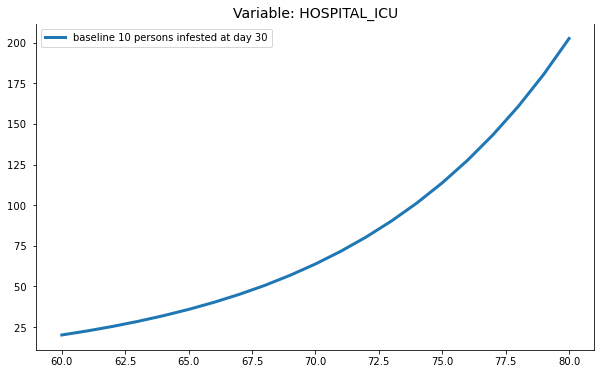

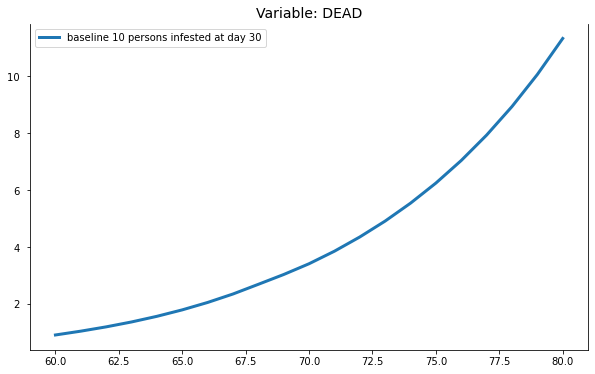

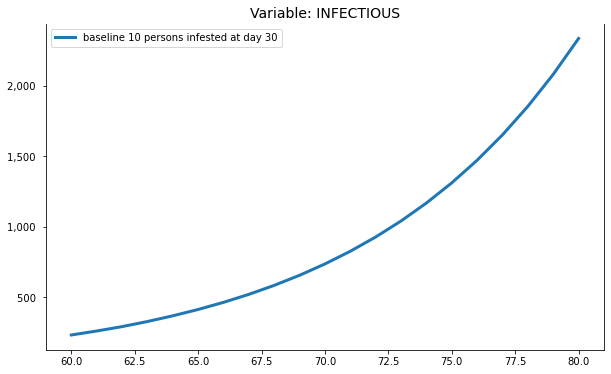

In [8]:
with mcorona.set_smpl(60,80):
    mcorona.keep_plot(' hospital_icu dead infectious',diff=0,legend=1,dec='0')

# Make eksperiments with a range of initial infections
Run and display 

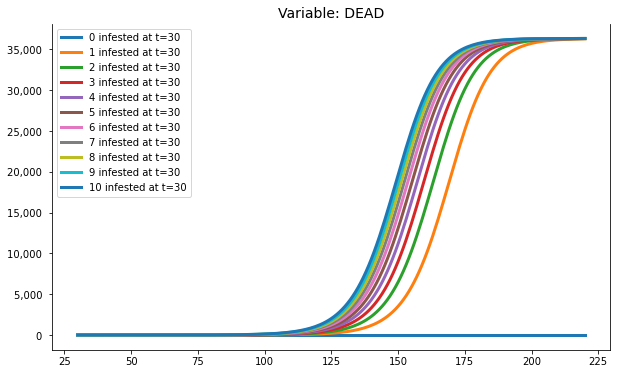

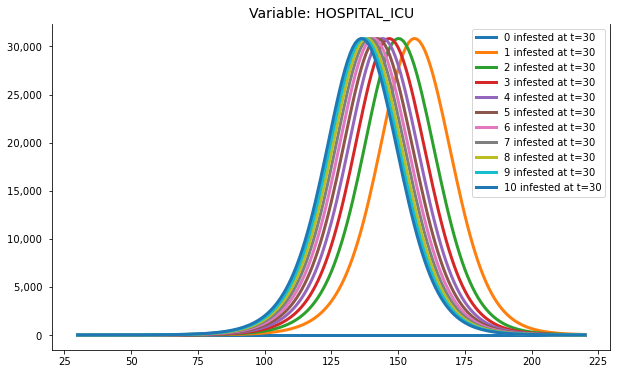

In [9]:
mcorona_infection = model.from_eq(rcorona)     # we make a model instance for this esperiment 
start = 30                                     # Day with infection
for infested in arange(0,11,1):                # Loop over values for number of infested from outside 
    eks = f'EXO_EXPOSED                    = {infested}        {start} {start}'    # Specify the update
    eksdf = model.update_from_list(newdf,eks)                                            # Update the baseline dataframe
    mcorona_infection(eksdf,keep = f'{infested} infested at t={start}');  # Run the model on the updated dataframe

with mcorona_infection.set_smpl(30,220):
    mcorona_infection.keep_plot('dead hospital_icu',diff=0,legend=1,dec='0');

## It can be useful to focus on smaller segments
The next cell allows you to specify the interval you want to see, and the variables you want to display. 

In [10]:
def viz(self,pat='*'):
    '''A utility function which shows selected variables over a selected timespan'''
    print(self)
    defaultvar = self.vlist(pat)
    def explain(smpl ,vars):
        with self.set_smpl(*smpl):
           figs =  self.keep_plot(' '.join(vars),diff=0,legend=1,dec='0')
            
    show = interactive(explain,
            smpl  = IntRangeSlider(value=[0,200],min=0,max=DAYS,layout=Layout(width='75%'),description='Show interval'),
            vars  = SelectMultiple(value = defaultvar,options=sorted(self.endogene)
                                      ,layout=Layout(width='50%', height='200px'),
                                       description='One or more'))
    
    display(show)
    return

mcorona_infection.keep_viz('DEAD HOSPITAL_ICU')

interactive(children=(IntRangeSlider(value=(20, 200), description='Show interval', layout=Layout(width='75%'),…

In [15]:
mcorona_rate_contact = model.from_eq(rcorona)     # we make a model instance for this esperiment 
start = 30                                     # Day with infection
newdf = model.update_from_list(basedf,basis)
for RATE_CONTACT in range(0,11,1):
    eks = f'''
    EXO_EXPOSED                    = 10       {start} {start}
    RATE_CONTACT                   = {RATE_CONTACT}
    '''
    eksdf = update_from_list(newdf,eks)
    mcorona_rate_contact(eksdf,keep = f'Rate of contact: {RATE_CONTACT}');

mcorona_rate_contact.keep_viz('DEAD HOSPITAL_ICU')

interactive(children=(IntRangeSlider(value=(20, 200), description='Show interval', layout=Layout(width='75%'),…

In [16]:
mcorona_transmission = model.from_eq(rcorona)     # we make a model instance for this esperiment 
start = 30                                     # Day with infection
newdf = model.update_from_list(basedf,basis)
for PROBABILITY_TRANSMISION in arange(0.00,0.1,0.01):
    eks = f'''
    EXO_EXPOSED                    = 10       {start} {start}
    RATE_CONTACT                   = 5
    PROBABILITY_TRANSMISION        = {PROBABILITY_TRANSMISION}
    '''
    eksdf = update_from_list(newdf,eks)
    mcorona_transmission(eksdf,keep_solution = f'Probability of transmission: {PROBABILITY_TRANSMISION}');

mcorona_transmission.viz('DEAD HOSPITAL_ICU')

<
Model name                              :            testmodel 
Model structure                         :         Simultaneous 
Number of variables                     :                   32 
Number of exogeneous  variables         :                    6 
Number of endogeneous variables         :                   26 
>


interactive(children=(IntRangeSlider(value=(0, 200), description='Show interval', layout=Layout(width='75%'), …

In [ ]:
# Define user interface 
mcorona.inputwidget(basedf = basedf,
                  slidedef = {
'Population            '              :{'var' : 'POPULATION SUSCEPTIBLE', 'min' : 0.0, 'max' : 100_000_000, 'value' : 10_000_000,'step':100_000,'op':'=start-','dec':0},
'Number of infected t=1'              :{'var' : 'EXO_EXPOSED',            'min' : 0.0, 'max' : 1000,       'value' : 1000,      'step':10,'op':'=impulse','dec':0},
'Share of infected with mild symptom' :{'var' : 'NEW_INFECTIOUS_TO_RECOVER_RATE',        'min' : 0.0, 'max' : 1.0,        'value' : 0.1,                'op':'='},
'Share in hospital no ICU and recover':{'var' : 'NEW_HOSPITAL_TO_RECOVER_RATE',          'min' : 0.0, 'max' : 1.0,        'value' : 0.01,               'op':'=' },
'Share in ICU which recovers'         :{'var' : 'NEW_INTENSIVE_TO_RECOVER_RATE',         'min' : 0.0, 'max' : 1.0,        'value' : 0.1,                'op':'='},
'Daily rate of contact'               :{'var' : 'RATE_CONTACT',           'min' : 0.0, 'max' : 30,         'value' : 0,'step':0.1,         'op':'='},
'Probability of transmission'         :{'var' : 'PROBABILITY_TRANSMISION','min' : 0.0, 'max' : 1.0,        'value' : 0.0,'step':0.005,  'op':'=','dec':3},
                             },
                 varpat='infectious recovered dead hospital* *_growth',showvar=True)